## Detecting Credit Card Fraud

Since we are working with preprocessed data, most of the features we are working with is obsecured. Good news is that we won't have to do much, if at all, data cleaning.

In [1]:
# Let's load the necessary packages and the data
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import time

df = pd.read_csv('../../../Data/creditcard.csv')
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


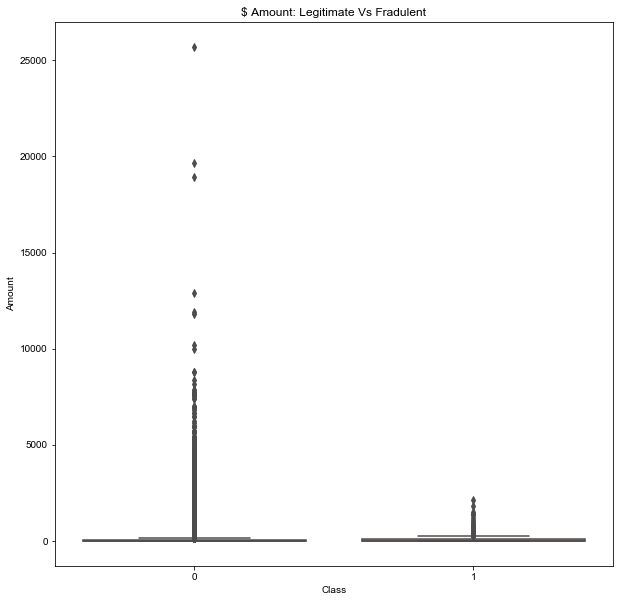

In [2]:
# I want to see if there is a significant difference in dollar amounts of legitimate vs fraudulent transactions
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style='white')

sns.boxplot(x='Class', y='Amount', data=df)
plt.title('$ Amount: Legitimate Vs Fradulent')
plt.show()


The dollar amounts for the legitimate tranasctions dwarf those of the fraudulent kind, so it looks like the amount alone isn't a very good indicator of fraud.

Since principal component analysis was already done, we can trust that the features have already been reduced to describe the data. So let's move on to see if we can build a model using the data. In the documents for the data, it was mentioned that there is a very small number of fraudulent transactions so let's take a look for ourselves.

In [3]:
# In order to see how we can split the data, I want to see how many records we are working with
df.shape

(284807, 31)

In [4]:
# 280k+ rows, so since the percentage of fraudulent transactions is very low, let's leave a sizeable test data.
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=26)
print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])

213605 71202 213605 71202


Let's use the vanilla logistic regression model to see how it does compared to ridge regression.

In [5]:
# start the clock
start_time = time.time()

lr = linear_model.LogisticRegression(solver='lbfgs', penalty='none')
lr_model = lr.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
c_mat = confusion_matrix(y_test, y_pred)

# measure elapsed time
elapsed = time.time() - start_time

print('Elapsed time: %0.2f seconds' % elapsed)
print('Coefficients:\n', lr_model.coef_)
print('R2 Score: ', lr_model.score(X_test, y_test))
print('Confusion Matrix:\n', c_mat)


Elapsed time: 1.73 seconds
Coefficients:
 [[-8.61984950e-05  4.58742559e-01 -8.13468164e-01 -7.93024314e-01
   2.40784726e-01  2.43191145e-01 -1.16982149e-01  4.12788544e-01
  -4.81611769e-01 -5.68307592e-01 -3.41137398e-01 -2.05237717e-01
  -4.46035763e-02 -4.50787376e-01 -1.08045390e+00 -4.14782817e-01
  -4.38092433e-01 -7.59195754e-01 -3.10311534e-02  6.97094742e-02
   6.17229661e-02  3.13219839e-01  3.62128912e-01  6.67046822e-02
  -2.30494582e-02 -3.85875302e-01  6.34267856e-02 -6.36541182e-02
   8.21358361e-02 -7.63027010e-03]]
R2 Score:  0.9990028369989608
Confusion Matrix:
 [[71033    37]
 [   34    98]]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Out of 71202 records, only 135 were flagged as fraudulent. Since the nature of the dataset has a skewed distribution, it is hard to celebrate our model's accuracy of 99.9%. It is also worrying that we flagged 37 legitimate transactions as fraudulent, while missing 34 fraudulent transactions. Put in context of total transactions, sensitivity(Type I or false positive) was 34/71084 or 0.05% and specificity(Type II or false negative) was 34/132 or 25.76%. In this case, we are more interested in falsely classified fraudulent transactions, since this means that we missed 25% of all fradulent transactions.

In [6]:
# Let's see if increasing the size of the training data will help
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=26)

start_time = time.time()

lr2 = linear_model.LogisticRegression(solver='lbfgs', penalty='none')
lr_model2 = lr2.fit(X_train, y_train)
y_pred = lr_model2.predict(X_test)
c_mat = confusion_matrix(y_test, y_pred)

elapsed = time.time() - start_time

print('Elapsed time: %0.2f seconds' % elapsed)
print('Coefficients:\n', lr_model2.coef_)
print('R2 Score: ', lr_model2.score(X_test, y_test))
print('Confusion Matrix:\n', c_mat)
print('Type II Error: ', c_mat[1][0]/sum(c_mat[1]))

Elapsed time: 1.67 seconds
Coefficients:
 [[-8.64852045e-05  4.99619948e-01 -8.55491289e-01 -8.05837795e-01
   2.32431174e-01  2.60382686e-01 -1.07872138e-01  4.35495163e-01
  -5.02360832e-01 -5.93688850e-01 -3.49378198e-01 -2.20131275e-01
  -1.83907968e-02 -4.63251504e-01 -1.11528994e+00 -4.28354454e-01
  -4.39727281e-01 -7.64006423e-01 -2.48020005e-02  6.64415129e-02
   6.02390438e-02  3.18291307e-01  3.77082281e-01  6.71750410e-02
  -2.77397511e-02 -3.89578391e-01  6.35397539e-02 -7.63894015e-02
   8.52842604e-02 -8.30248182e-03]]
R2 Score:  0.9989642217618764
Confusion Matrix:
 [[56825    28]
 [   31    78]]
Type II Error:  0.28440366972477066


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


So our type II error got worse to 28.44%. Let's go back to leaving out 25% of data for testing and try gradient boosting model to compare its performance.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=26)
print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])
print(y_test.value_counts())

213605 71202 213605 71202
0    71070
1      132
Name: Class, dtype: int64


In [36]:
# gradient boost model

start_time = time.time()

clf = ensemble.GradientBoostingClassifier(n_estimators=900, max_depth=11)
clf_model = clf.fit(X_train, y_train)
clf_y_pred = clf_model.predict(X_test)
clf_c_mat = confusion_matrix(y_test, clf_y_pred)

elapsed = time.time() - start_time

print('Elapsed time: %0.2f seconds' % elapsed)
print('Accuracy: ', clf_model.score(X_test, y_test))
print('Confusion Matrix:\n', clf_c_mat)
print('Type II Error: ', clf_c_mat[1][0]/sum(clf_c_mat[1]))

Elapsed time: 70.34 seconds
Accuracy:  0.9992556388865481
Confusion Matrix:
 [[71042    28]
 [   25   107]]
Type II Error:  0.1893939393939394


Our gradient boosting model gave us 28.79% specificity. Marked improvement as it should be for an ensemble model.

In [37]:
# Random forest model

start_time = time.time()

rfc = ensemble.RandomForestClassifier(n_estimators=900, max_depth=11)
rfc_model = rfc.fit(X_train, y_train)
rfc_y_pred = rfc_model.predict(X_test)
rfc_c_mat = confusion_matrix(y_test, rfc_y_pred)

elapsed = time.time() - start_time

print('Elapsed time: %0.2f seconds' % elapsed)
print('Accuracy: ', rfc_model.score(X_test, y_test))
print('Confusion Matrix:\n', rfc_c_mat)
print('Type II Error: ', rfc_c_mat[1][0]/sum(rfc_c_mat[1]))

Elapsed time: 734.08 seconds
Accuracy:  0.9996348417179293
Confusion Matrix:
 [[71067     3]
 [   23   109]]
Type II Error:  0.17424242424242425


Random forest classifier gets us 22.01% and mis-classified 24 out of 109 fraudulent transactions.

In [10]:
# SVM classifier

start_time = time.time()

svc = svm.SVC(kernel='linear')
svc_model = svc.fit(X_train, y_train)
svc_y_pred = svc_model.predict(X_test)
svc_c_mat = confusion_matrix(y_test, svc_y_pred)

elpased = time.time() - start_time

print('Elapsed time: %0.2f seconds' % elapsed)
print('Accuracy: ', svc_model.score(X_test, y_test))
print('Confusion Matrix:\n', svc_c_mat)
print('Type II Error: ', svc_c_mat[1][0]/sum(svc_c_mat[1]))

Elapsed time: 222.61 seconds
Accuracy:  0.9984691441251651
Confusion Matrix:
 [[71049    21]
 [   88    44]]
Type II Error:  0.6666666666666666


In [18]:
# KNN Classifier

start_time = time.time()

knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn_model = knn.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_test)
knn_c_mat = confusion_matrix(y_test, knn_y_pred)

elapsed = time.time() - start_time

print('Elapsed time: %0.2f seconds' % elapsed)
print('Accuracy: ', knn_model.score(X_test, y_test))
print('Confusion Matrix:\n', knn_c_mat)
print('Type II Error: ', knn_c_mat[1][0]/sum(knn_c_mat[1]))

Elapsed time: 3.55 seconds
Accuracy:  0.9982865649841297
Confusion Matrix:
 [[71069     1]
 [  121    11]]
Type II Error:  0.9166666666666666


In [14]:
# Naive-Bayes classifier

start_time = time.time()

bn = BernoulliNB()
bn_model = bn.fit(X_train, y_train)
bn_y_pred = bn_model.predict(X_test)
bn_c_mat = confusion_matrix(y_test, bn_y_pred)

elapsed = time.time() - start_time

print('Elasped time: %0.2f seconds' % elapsed)
print('Accuracy: ', bn_model.score(X_test, y_test))
print('Confusion Matrix:\n', bn_c_mat)
print('Type II Error: ', bn_c_mat[1][0]/sum(bn_c_mat[1]))

Elasped time: 0.23 seconds
Accuracy:  0.9992135052386169
Confusion Matrix:
 [[71055    15]
 [   41    91]]
Type II Error:  0.3106060606060606
